<h3>Prediction of Customer Churn Rates for a Telecommunications Business</h3>

<b>Introduction</b>
<p> This data science project is about predicting the likelihood of customers of a telecom company to churn. "Customer Churn Rate" is defined as the percentage of customers that stopped using a company's product or service during a certain time frame.Analyzing the churn rate and underlying factors is important because in man cases its more costly to acquire new customers than it does to retain them . Additionally, he higher the customer retention, the more the profitability and business growth. It's also a good indicator of whether the product, service or team are succeeding.</p>                                                                                                                                           
<p>The data is carefully processed through data cleaning, exploration and feature engineering. This is a classification problem. Based on the nature of the dataset, I selected the most suitable classifiers which are Logistic Regression, Random Forest and Gradient Boost Classifier. I performed hyperparameter tuning using randomsearCV to optimize the models. I selected the best model in predicting the Churn. Since the target variable was imbalanced, I opted to use ROC AUC instead of accuracy. I also used 5 fold cross-validation to minimize over-fitting.  I identified features most influencial in the predictive model. I performed statistical analysis to get an overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures like the odds ratio.
</p>  

In [0]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

<b>Exploratory Data Analysis</b>

In [0]:
#Load the data
telecom_df=pd.read_csv("https://raw.githubusercontent.com/sembahen/Data_Files/master/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [0]:
#View the first few rows
telecom_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
#Statistical descritin of the numeric features
telecom_df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [0]:
#Vieweing the data types. Note that the total charges is dtype object to I'll have to change it to 
#numeric
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [0]:
#Null values
telecom_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [0]:
#Shape of the dataset
telecom_df.shape

(7043, 21)

In [0]:
#looking at the Total Charges column
telecom_df["TotalCharges"]

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [0]:
telecom_df["TotalCharges"].isnull().sum()

0

The feature "TotalCharges" was of type "object" and we are changing it to type "numeric"

In [0]:
#telecom_df[telecom_df["TotalChages"].apply(lambda x: True if type(x) == str else False)]["TotalChages"]
telecom_df["TotalCharges"] = telecom_df["TotalCharges"].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

In [0]:
telecom_df["TotalCharges"].isnull().sum()

0

In [0]:
#checking the info again to make sure the TotalCharges are now a numeric dtype
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

In [0]:
#Examining the column Tenure column
telecom_df["tenure"].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [0]:
#Looking at the distribution of the target variable
telecom_df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

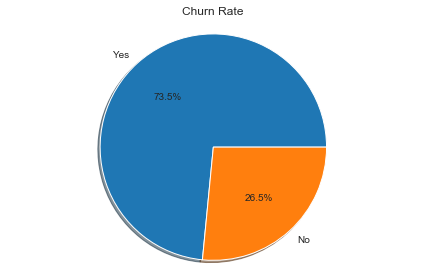

In [0]:
#check for the current pie chart
labels=['Yes', 'No']
sizes=[5174,1869]

#Plot a pie chart to show distribution
plt.pie(sizes, labels=labels, autopct='%1.1f%%' , shadow=True)

plt.axis('equal')
plt.title("Churn Rate")
plt.tight_layout()

The target variable is not balanced. We have 73% YES and 27% NO. Because of this, instead of using accuracy, I will use AUC to analyze performance.

In [0]:
#Delete the customer ID column. It's useless
telecom_df=telecom_df.drop(['customerID'], axis=1)

In [0]:
#Lookling at the non_numeric columns
non_numeric_columns=telecom_df.select_dtypes(["object"]).columns
print(non_numeric_columns)
print("The number of non_numeric columns is {}".format(len(non_numeric_columns)))

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')
The number of non_numeric columns is 16


In [0]:
#Lookling at the numeric columns
numeric_columns=telecom_df.select_dtypes(["int64","float64"]).columns
print(numeric_columns)
print("The number of numeric columns is {}".format(len(numeric_columns)))

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')
The number of numeric columns is 4


In [0]:

telecom_df.shape

(7043, 20)

In [0]:
#Object type parameters
telecom_df_objects=['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaperlessBilling', 'PaymentMethod']

In [0]:
#Changing the churn column dtype to numeric
def new_label(x):
    if x=='Yes':
        return 1
    else:
        return 0
telecom_df_analysis=telecom_df.copy()    
telecom_df_analysis['Churn'] = telecom_df_analysis['Churn'].apply(new_label)  

In [0]:
#Examining the column Tech Support
telecom_df_analysis['TechSupport'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [0]:
telecom_df_analysis["Churn"].unique()

array([0, 1], dtype=int64)

Visualization of calegorical variables associated with Churn Rate

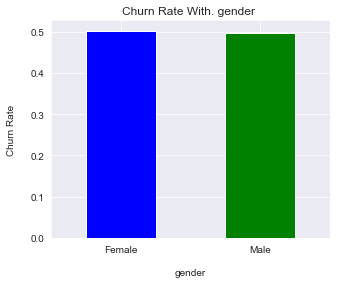

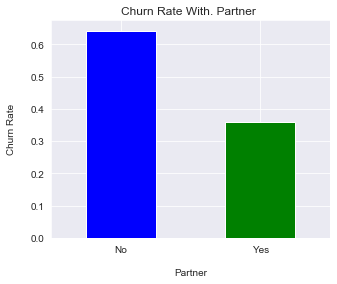

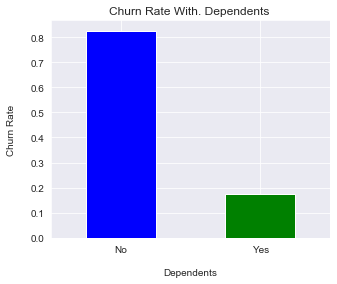

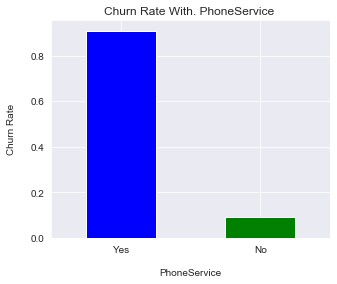

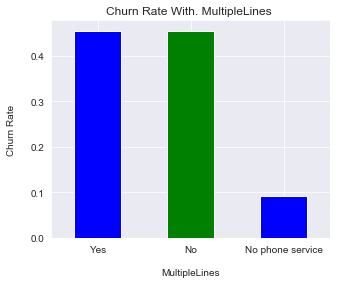

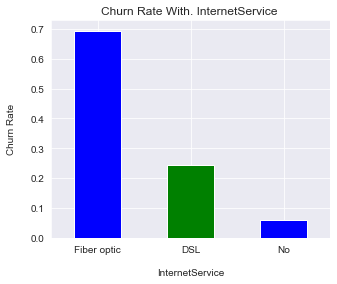

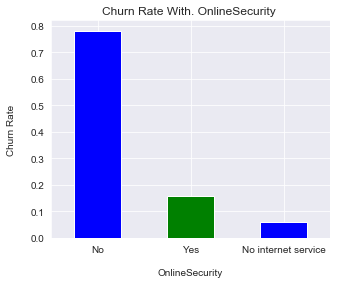

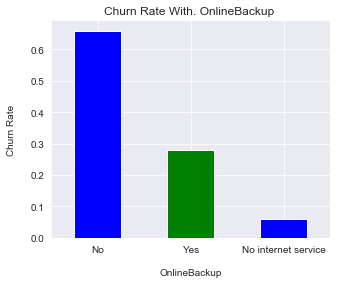

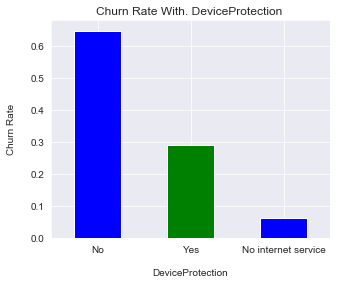

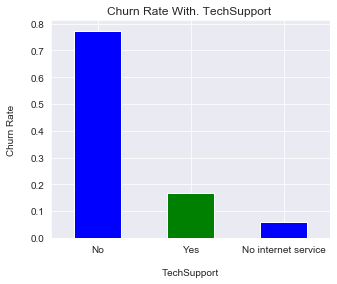

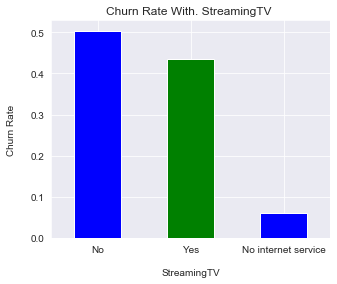

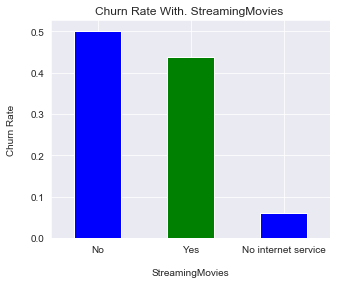

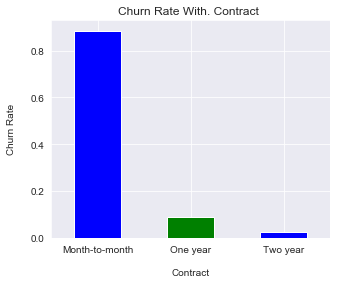

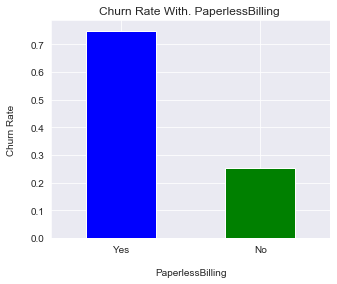

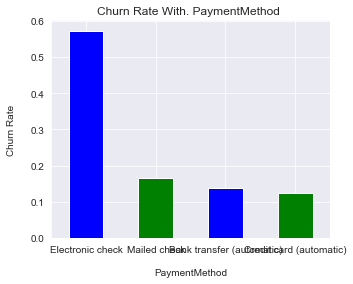

In [0]:
#churn=yes
telecom_churn=telecom_df[telecom_df.Churn=="Yes"]
telecom_churn.drop(["MonthlyCharges", "TotalCharges"], axis=1)

#ax = sns.catplot(x=['TechSupport', 'PhoneService'],kind=['count','count']data=telecom_churn,orient="h")
#ax.fig.autofmt_xdate()
for x in telecom_df_objects: 
  telecom_churn[x].value_counts(normalize =True).plot(kind='bar', figsize=(5, 4), rot=0,color=('blue',"green"))
  plt.xlabel(x, labelpad=14)
  plt.ylabel("Churn Rate", labelpad=14)
  plt.title("Churn Rate With. {} ".format(x))
  plt.show()

Text(0.5, 1.0, 'Distribution of Tech Support')

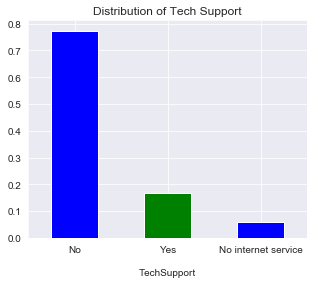

In [0]:
#what proportion of customers use tech support?
telecom_churn['TechSupport'].value_counts(normalize =True).plot(kind='bar', figsize=(5, 4), rot=0,color=('blue',"green"))
plt.xlabel("TechSupport", labelpad=14)
plt.title("Distribution of Tech Support")

Text(0.5, 1.0, 'Gender Distribution ')

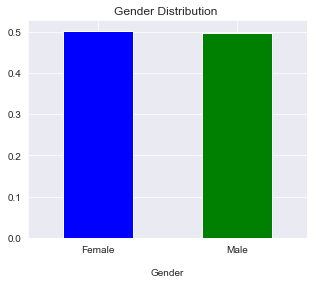

In [0]:
#what is the gender distribution?
telecom_churn['gender'].value_counts(normalize =True).plot(kind='bar', figsize=(5, 4), rot=0,color=('blue',"green"))
plt.xlabel("Gender", labelpad=14)
plt.title("Gender Distribution ")

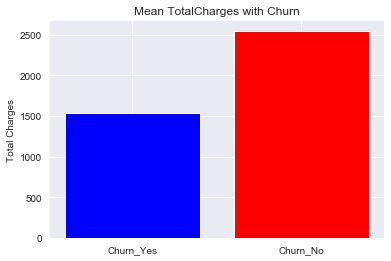

In [0]:
#Visualizing the relationship between the total charges and churn rate

churn_yes=telecom_df[telecom_df.Churn=="Yes"].TotalCharges.mean()
churn_no=telecom_df[telecom_df.Churn=="No"].TotalCharges.mean()
height=(churn_yes,churn_no)
bars=("Churn_Yes","Churn_No")
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color=['blue', 'red'])
plt.xticks(y_pos, bars)
plt.title('Mean TotalCharges with Churn')
plt.ylabel('Total Charges')
plt.show()

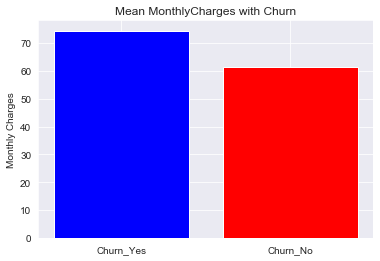

In [0]:
#Visualizing the relationship between the total charges and churn rate
churn_yes=telecom_df[telecom_df.Churn=="Yes"].MonthlyCharges.mean()
churn_no=telecom_df[telecom_df.Churn=="No"].MonthlyCharges.mean()
height=(churn_yes,churn_no)
bars=("Churn_Yes","Churn_No")
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color=['blue', 'red'])
plt.xticks(y_pos, bars)
plt.title('Mean MonthlyCharges with Churn')
plt.ylabel('Monthly Charges')
plt.show()

Label encoding the object type data

In [0]:
#Label encoding the object type data
telecom_df2=telecom_df.copy()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from sklearn.pipeline import Pipeline

telecom_df2['gender'] =  label_encoder.fit_transform(telecom_df2['gender'])
telecom_df2['Partner'] =  label_encoder.fit_transform(telecom_df2['Partner'])
telecom_df2['Dependents'] =  label_encoder.fit_transform(telecom_df2['Dependents'])
telecom_df2['PhoneService'] =  label_encoder.fit_transform(telecom_df2['PhoneService'])
telecom_df2['MultipleLines'] =  label_encoder.fit_transform(telecom_df2['MultipleLines'])
telecom_df2['InternetService'] =  label_encoder.fit_transform(telecom_df2['InternetService'])
telecom_df2['OnlineSecurity'] =  label_encoder.fit_transform(telecom_df2['OnlineSecurity'])
telecom_df2['OnlineBackup'] =  label_encoder.fit_transform(telecom_df2['OnlineBackup'])
telecom_df2['DeviceProtection'] =  label_encoder.fit_transform(telecom_df2['DeviceProtection'])
telecom_df2['TechSupport'] =  label_encoder.fit_transform(telecom_df2['TechSupport'])
telecom_df2['StreamingTV'] =  label_encoder.fit_transform(telecom_df2['StreamingTV'])
telecom_df2['StreamingMovies'] =  label_encoder.fit_transform(telecom_df2['StreamingMovies'])
telecom_df2['Contract'] =  label_encoder.fit_transform(telecom_df2['Contract'])
telecom_df2['PaperlessBilling'] =  label_encoder.fit_transform(telecom_df2['PaperlessBilling'])
telecom_df2['PaymentMethod'] =  label_encoder.fit_transform(telecom_df2['PaymentMethod'])
telecom_df2['Churn'] =  label_encoder.fit_transform(telecom_df2['Churn'])

In [0]:
#This dataset is for the generation of the heatmap. Checking to make sure it's all label encoded
telecom_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null int32
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int32
Dependents          7043 non-null int32
tenure              7043 non-null int64
PhoneService        7043 non-null int32
MultipleLines       7043 non-null int32
InternetService     7043 non-null int32
OnlineSecurity      7043 non-null int32
OnlineBackup        7043 non-null int32
DeviceProtection    7043 non-null int32
TechSupport         7043 non-null int32
StreamingTV         7043 non-null int32
StreamingMovies     7043 non-null int32
Contract            7043 non-null int32
PaperlessBilling    7043 non-null int32
PaymentMethod       7043 non-null int32
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null int32
dtypes: float64(2), int32(16), int64(2)
memory usage: 660.4 KB


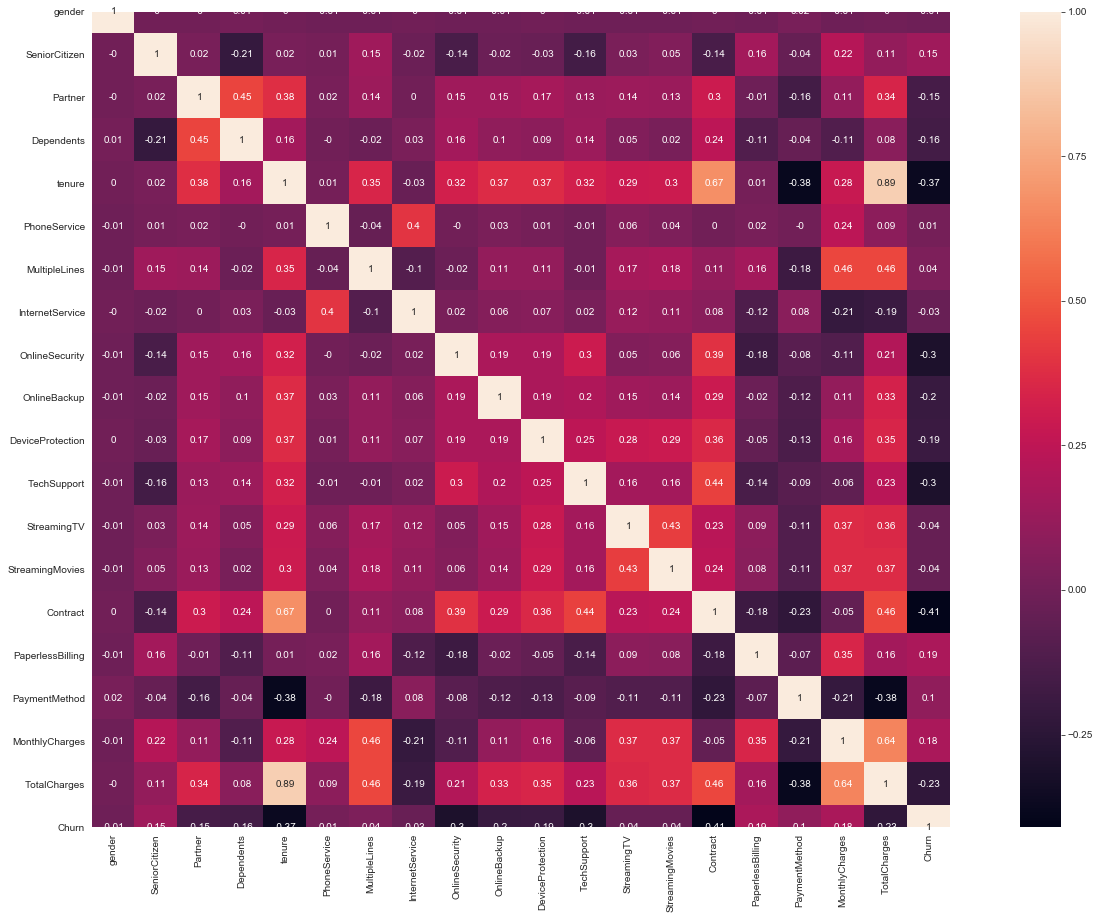

In [0]:
#drawing the heatmap. I am looking for features that are closely related. If any, I would do some 
#further feature engineering to see which ones can be eliminated
plt.figure(figsize=(25,15))
corrmat=telecom_df2.corr(method ='spearman').round(2)
sns.heatmap(corrmat, square=True, annot=True,xticklabels=True, yticklabels=True)

In [0]:
#I didn't find any features that were too closely related with a strong negative
#correlation to warrant elimination

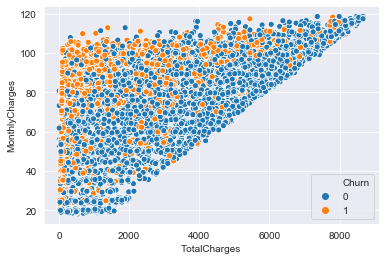

In [0]:
#Total charges vs monthly charges
sns.scatterplot(x="TotalCharges", y="MonthlyCharges", hue="Churn",  data=telecom_df2);

Outlier Detection

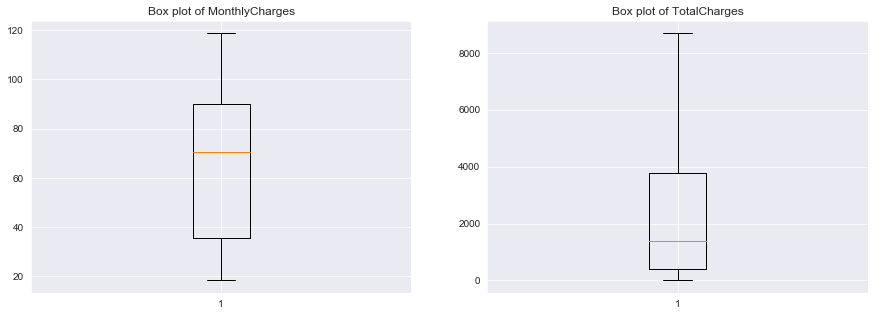

In [0]:
#Box plot for the continuous variables in the dataset
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(telecom_df["MonthlyCharges"])
plt.title("Box plot of MonthlyCharges")

plt.subplot(1,2,2)
plt.boxplot(telecom_df["TotalCharges"])
plt.title("Box plot of TotalCharges")
plt.show()

In [0]:
#no outliers

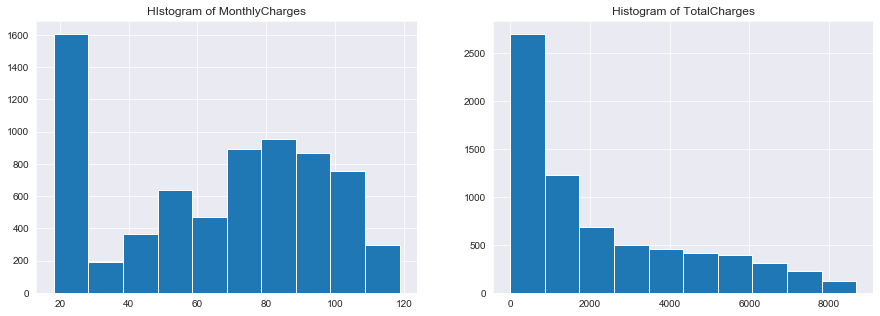

In [0]:
#Histogram  for the continuous variables in the dataset
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(telecom_df["MonthlyCharges"])
plt.title("HIstogram of MonthlyCharges")

plt.subplot(1,2,2)
plt.hist(telecom_df["TotalCharges"])
plt.title("Histogram of TotalCharges")
plt.show()

In [0]:
#Examining the object type variables and their unique values
telecom_df3=telecom_df.copy()
categorical = telecom_df3.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

gender
2
Partner
2
Dependents
2
PhoneService
2
MultipleLines
3
InternetService
3
OnlineSecurity
3
OnlineBackup
3
DeviceProtection
3
TechSupport
3
StreamingTV
3
StreamingMovies
3
Contract
3
PaperlessBilling
2
PaymentMethod
4
Churn
2


Next is the modeling process.
I begin by doing one Hot encoding

In [0]:
#Using one hot encoding to convert object type categorical features to numeric
cat_vars=['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod',
          'gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(telecom_df3[var], prefix=var)
    data1=telecom_df3.join(cat_list)
    telecom_df3=data1
cat_vars=['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod',
          'gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
data_vars=telecom_df3.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [0]:
telecom_df4=telecom_df3[to_keep]

In [0]:
telecom_df4.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mai

In [0]:
#Removing repetition after applying dummies for the Binary cateforical variables
telecom_df4=telecom_df4.drop(['gender_Female','Partner_No','Dependents_No','PhoneService_No','PaperlessBilling_No','Churn_No'], axis=1)
telecom_df4 = telecom_df4.rename(columns = {'Churn_Yes': 'Churn'})
telecom_df4.columns


Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mai

In [0]:
telecom_df4.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,Churn
0,0,1,29.85,29.85,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
2,0,2,53.85,108.15,1,0,0,1,0,0,...,0,0,0,1,1,0,0,1,1,1
3,0,45,42.30,1840.75,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,1


In [0]:
#the data is now ready for machine learning
telecom_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
SeniorCitizen                              7043 non-null int64
tenure                                     7043 non-null int64
MonthlyCharges                             7043 non-null float64
TotalCharges                               7043 non-null float64
MultipleLines_No                           7043 non-null uint8
MultipleLines_No phone service             7043 non-null uint8
MultipleLines_Yes                          7043 non-null uint8
InternetService_DSL                        7043 non-null uint8
InternetService_Fiber optic                7043 non-null uint8
InternetService_No                         7043 non-null uint8
OnlineSecurity_No                          7043 non-null uint8
OnlineSecurity_No internet service         7043 non-null uint8
OnlineSecurity_Yes                         7043 non-null uint8
OnlineBackup_No                            7043 non-null uint8
OnlineB

In [0]:
#Prepare training and testing data
from sklearn.model_selection import train_test_split, cross_val_score
y=telecom_df4["Churn"]
X=telecom_df4.drop(["Churn"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=465)

In [0]:
#All predictors
predictors=['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes']

In [0]:
from sklearn.metrics import roc_auc_score

<h2> Machine Learning</h2>

I use 3 classifiers : Logistic Regression, Random Forest and GBC to fit and predict the model. I then
    compare their performance using AUC and recommend the best performer

<h3>1. Logistic Regression</h3>

<b>a) Ligistic Regression-Baseline Model( Without optimization)</b>

In [0]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_cv_scores = cross_val_score(lr_clf, X, y, cv=5,scoring="roc_auc")
print('The AUC scores: ', lr_cv_scores)
print('Mean cross validation score: {:.3f}'.format(lr_cv_scores.mean()))


The AUC scores:  [0.85704875 0.85546514 0.83274303 0.83855434 0.83803755]
Mean cross validation score: 0.844


<b>b) Ligistic Regression( With optimization)</b>

In [0]:
#Logistic regression with randomized search
# Load libraries
from scipy.stats import uniform
from sklearn import linear_model, datasets
from sklearn.model_selection import RandomizedSearchCV
logistic = linear_model.LogisticRegression()

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

#regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [0]:
# Create randomized search 5-fold cross validation with 100 iterations
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=123, n_iter=100, cv=5, verbose=2, n_jobs=-1)

# Fit the model
best_model = clf.fit(X_train, y_train)
print(best_model.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.8s finished
C:\Users\sembahen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 0.3684197597803007, 'penalty': 'l1'}


In [0]:
#predicting the churn

lr_clf = LogisticRegression(solver='liblinear', penalty='l1', C=0.3684197597, max_iter=1000)

lr_cv_scores = cross_val_score(lr_clf, X, y, cv=5,scoring="roc_auc")
print('The AUC scores: ', lr_cv_scores)
print('Mean cross validation score: {:.3f}'.format(lr_cv_scores.mean()))

The AUC scores:  [0.85834302 0.85876153 0.83322354 0.83872872 0.83944545]
Mean cross validation score: 0.846


The hyperparameter tuning improved the score from 0.845 to 0.846. It is not massive but it is an improvement. I tried other potential solvers and they all returned 0.846  

<h3>2. Random Forest</h3>

<b>a) Random Forest-Baseline Model( Without optimization)</b>

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


In [0]:
#A) Without optimization


rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

rfc_cv_scores = cross_val_score(rfc, X, y, cv=5,scoring="roc_auc")
print('The AUC scores without optimization: ', rfc_cv_scores)
print('Mean cross validation score: {:.3f}'.format(rfc_cv_scores .mean()))

C:\Users\sembahen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The AUC scores without optimization:  [0.79513421 0.80672066 0.77571495 0.79218657 0.79060081]
Mean cross validation score: 0.792


In [0]:
#Cross validation with RandomForest

rfc = RandomForestClassifier()
# NUMBER OF TREES TO USE
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 6000, num = 10)]
# NUMBER OF FEATURES AT EVERY SPLIT
max_features = ['auto', 'sqrt']
# MAX DEPTH OF THE TREES
max_depth = [int(x) for x in np.linspace(2, 75, num = 11)]
max_depth.append(None)
# PUT IT ALL TOGETHER AND CREATE A RANDOM GRID
random_grid = {
'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth
}
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid,
                                n_iter = 100, cv = 5, random_state=4424, verbose=2,  n_jobs=-1)



<b>b) Random Forest( With optimization)</b>

In [0]:
#Fit the RF model
import random
np.random.seed(123)
rfc_random.fit(X_train, y_train)
print(rfc_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 29.2min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 72.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 102.2min finished


{'n_estimators': 6000, 'max_features': 'sqrt', 'max_depth': 9}


In [0]:
#Fitting the model after obtaining the hyperparameters
rf_clf = RandomForestClassifier(n_estimators=6000, max_features="sqrt", max_depth=9, random_state=400)

rf_clf.fit(X_train, y_train)
rf_cv_scores = cross_val_score(rf_clf, X, y, cv=5,scoring="roc_auc")

print('The AUC scores with optimization: ', rf_cv_scores)
print('Mean cross validation score: {:.3f}'.format(rf_cv_scores .mean()))

The AUC scores with optimization:  [0.85935312 0.85707975 0.830759   0.83396884 0.84361728]
Mean cross validation score: 0.845


With the hyperpatameter tuning I was able to improve the AUC score from 0.792 to 0.845 , an increment of 7%.

<h3>3. GBC</h3>

<b>a) GBC-Baseline Model( Without optimization)</b>

In [0]:
#using gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [0]:
#A) Without optimization
gbc = GradientBoostingClassifier(random_state=234)
gbc.fit(X_train, y_train)
gbc_cv_scores = cross_val_score(gbc, X, y, cv=5,scoring="roc_auc")
print('The AUC scores without optimization: ', gbc_cv_scores)
print('Mean cross validation score: {:.3f}'.format(gbc_cv_scores .mean()))

The AUC scores without optimization:  [0.85807952 0.85621044 0.83156759 0.84001653 0.84475812]
Mean cross validation score: 0.846


<b>b) GBC( With optimization)</b>

In [0]:
gbc = GradientBoostingClassifier()
 #NUMBER OF TREES TO USE
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 4000, num = 10)]
 #NUMBER OF FEATURES AT EVERY SPLIT
max_features = [6,8]
 #MAX DEPTH OF THE TREES
max_depth = [int(x) for x in np.linspace(3, 21, num = 3)]
max_depth.append(None)
 #PUT IT ALL TOGETHER AND CREATE A RANDOM GRID
random_grid = {
'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth
}
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid,
                                n_iter = 100, cv = 5, random_state=4424, verbose=2, n_jobs=-1)

In [0]:
import random
np.random.seed(123)
gbc_random.fit(X_train, y_train)
print(gbc_random.best_params_)

C:\Users\sembahen\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 72.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 86.7min finished


{'n_estimators': 100, 'max_features': 8, 'max_depth': 3}


In [0]:
#Fitting the model after obtaining the hyperparameters

gb_clf = GradientBoostingClassifier(n_estimators=100, max_features=8, max_depth=3, random_state=234)
gb_clf.fit(X_train, y_train)
gbc_cv_scores = cross_val_score(gb_clf, X, y, cv=5,scoring="roc_auc")
print('The AUC score via GBC: {}'.format(gbc_cv_scores))
print('Mean cross validation score: {:.3f}'.format(gbc_cv_scores .mean()))

The AUC score via GBC: [0.86144437 0.85961792 0.83345734 0.84187269 0.84481775]
Mean cross validation score: 0.848


With GBC, I improved the AUC score from 0.846 to 0.848. GBC is also my best performing model

<b>Feature Importance Analysis</b>

I performed feature importance analysis to invesigate which feature were more impactful in the prediction of the target variable

Text(0, 0.5, 'Feature Importance Score')

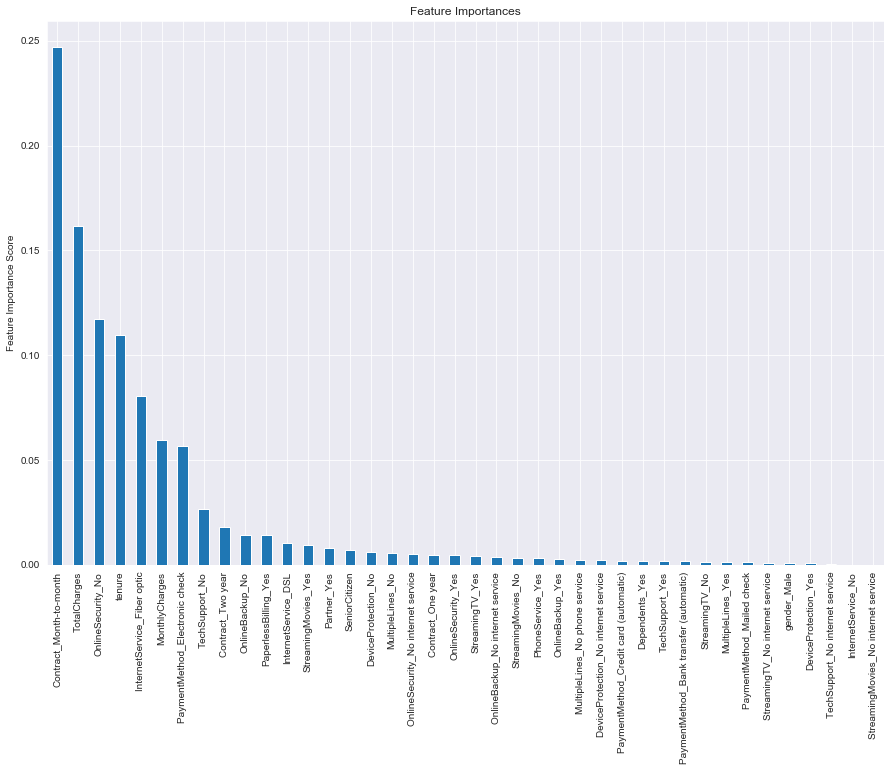

In [0]:
#Print Feature Importance:
#plt.figure(figsize=(12,4))
#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 12, 4
feat_imp = pd.Series(gb_clf.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances',figsize=(15,10))
plt.ylabel('Feature Importance Score')
#plt.show()

I performed statistical analysis on the most influential features to quantify their impact and to get an overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures like the odds ratio.

In [0]:
import statsmodels.api as sm


In [0]:
import statsmodels.api as sm
X3=X[['Contract_Month-to-month','TotalCharges','OnlineSecurity_No','InternetService_Fiber optic']]
# We need to manually add a constant
# in statsmodels' sm
X3 = sm.add_constant(X3)

logit = sm.Logit(y,X3).fit()

print(results.summary())
print(results.conf_int())


C:\Users\sembahen\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\sembahen\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     482.7
Date:                Sun, 19 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:37:36   Log-Likelihood:                -3197.5
No. Observations:                7043   AIC:                             6407.
Df Residuals:                    7037   BIC:                             6448.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------

Confidence interval

In [0]:
print(results.conf_int())

                                    0         1
const                        0.130899  0.188607
Contract_Month-to-month      0.112196  0.163007
TotalCharges                -0.000026 -0.000008
OnlineSecurity_No            0.095637  0.137451
InternetService_Fiber optic  0.198601  0.247863
tenure                      -0.003506 -0.001845


I exponentiate the the results and get the odds ratio to quantify the impact of these features

In [0]:
print(np.exp(results.params))


const                          1.173221
Contract_Month-to-month        1.147518
TotalCharges                   0.999983
OnlineSecurity_No              1.123607
InternetService_Fiber optic    1.250110
tenure                         0.997328
dtype: float64


This implies that,for example, for a unit increase in contract month to month, there is a resulting 14% increase in churn. This is telling in terms of potential recommendations to the business on which variables of greater impact in mitigating churn. 

<h3>Summary</h3>

<p>Through hyperparameter tuning, I improved the performance of the 3 models used: Logistic Reression improved by 0.1%, Random Forest by 7% and Gradient Boost Classifier by 0.2%. I used 5 fold cross validation as a means of minimizing overfitting. I used ROC AUC as opposed to accuracy because the target variable is imbalanced(73.5% Churn==Yes and 26.5% Churn==No).Gradient Boost Classifier turned out to be the best performer with AUC score of 0.848. I used statistical analysis to investigate the parameters of greater feature importance in predicting the model. Some of the features include total charges, online security, Internet services, tenure. 
I found the Odds Ratio to be quite useful as it explonentiating the terms to provide a more presentable format. From an analytics stantpoint, it would be interesting to know whether the high percentage of churn is due to less data colleced from customers who didn't churn or whether the company is losing a large percentage of customers? However, that is beyond the scope of this research. For future work, I would look into other ensemble methods to see if I can improve the model performance.</p>
